In [18]:
import os
from glob import glob
from pathlib import Path

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from datetime import datetime, timedelta
import networkx as nx
import scipy.sparse as sp
from random import shuffle
from scipy.sparse import coo_matrix,csr_matrix
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import matplotlib as mpl
from random import randint
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from itertools import combinations


from pylab import hist, xticks, xlabel,ylabel
from sklearn.linear_model import LinearRegression

import gc
from pyvis.network import Network


%matplotlib inline
import json

In [7]:
import os
os.environ["LC_ALL"] = "en_US.UTF-8"
os.environ["LANG"] = "en_US.UTF-8"

%load_ext rpy2.ipython


[1] 0.2
[1] 0.4
[1] 0.6
[1] 0.8
[1] 1


In addition: There were 12 warnings (use warnings() to see them)


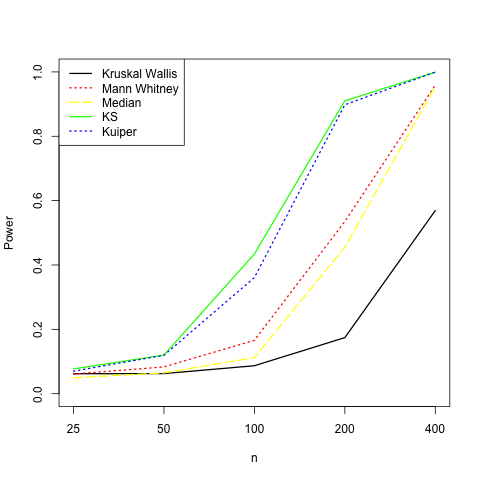

In [9]:
%%R
options(repos = "https://cloud.r-project.org")

suppressPackageStartupMessages({
  library(jsonlite)
  library(dplyr)
})

for (pkg in c("rmutil","dgof")) {
  if (!requireNamespace(pkg, quietly = TRUE)) {
    try(install.packages(pkg, dependencies = TRUE), silent = TRUE)
  }
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}

# --- Fix for GitHub scripts using legend(bottomright, ...) without quotes ---
# Define symbols that those scripts expect as variables
positions <- c("bottomright","bottom","bottomleft",
               "left","topleft","top","topright","right","center")
for (p in positions) assign(p, p, envir = .GlobalEnv)
# ---------------------------------------------------------------------------

source("TwoSample.R")
source("Tulap.R")


In [37]:
def get_week_data(all_data, s_date):
    all_data["creation_time"]=pd.to_datetime(all_data["creation_time"])
    twitter_telegram_activity_df = all_data[all_data["creation_time"].between(s_date,s_date+timedelta(days=7))]
    
    return twitter_telegram_activity_df.sort_values("creation_time",ascending=True)


def calculate_silences(df, legit_users):
    print("calculating silences")
    silences_list = []


    silences_dict = {}
    for add in legit_users:
        add_data = df[(df["creator_name"]==add)]
        if len(add_data)>10:         
            silences_period = add_data["creation_time"].sort_values().diff().dt.seconds.sort_values().dropna()+1
            silences_dict[add] = {"silence_arr":silences_period.values}
            silences_list.append({"add":add, "silence_arr":list(silences_period.values), "label":str(add_data["label"].values[0])})

    silences_df = pd.DataFrame.from_dict(silences_dict,orient="index",columns=["silence_arr"])
    silences_df["len_silences"]  = silences_df["silence_arr"].apply(lambda x: len(x))
    silences_df["len_diff_silences"]  = silences_df["silence_arr"].apply(lambda x: len(set(x)))

    silences_df = silences_df[silences_df["len_silences"]>0]
    min_num_diff_silences_df = silences_df[silences_df["len_diff_silences"]>10].reset_index()
    min_num_diff_silences_df = min_num_diff_silences_df.rename({"index":"address"},axis=1)
    min_num_diff_silences_df["index"]=range(len(min_num_diff_silences_df))
    return silences_list, min_num_diff_silences_df


"""
Calculate exact (non private) KS 
"""
def calc_non_private_ks(intermediate_results_path, orgA_name, orgB_name):
    file_path = os.path.join(intermediate_results_path, "silences_%s.json"%orgA_name)
    with open(file_path, 'r') as json_file:
        data_dict = json.load(json_file)
    
    orgA_silences_df = pd.DataFrame(data_dict)
    
    
    file_path = os.path.join(intermediate_results_path,"silences_%s.json"%orgB_name)
    with open(file_path, 'r') as json_file:
        data_dict = json.load(json_file)
    orgB_silences_df = pd.DataFrame(data_dict)
    
    
    
    
        
       
        
    ks_res = []
    for addA, silence_listA, labelA in orgA_silences_df.values:
        for addB, silencelistB, labelB in orgB_silences_df.values:
            result = ks_2samp(silence_listA, silencelistB)
            ks_dist = result[0]
            ks_p_val = result[1]
            ks_res.append((addA, addB, ks_dist, ks_p_val, labelA, labelB))
    orig_ks_df = pd.DataFrame(ks_res, columns= ["orgA_id", "orgB_id", "ks", "pval","orgA_label","orgB_label"])
    orig_ks_df["correct"] = orig_ks_df["orgA_label"]==orig_ks_df["orgB_label"]
    orig_ks_df = orig_ks_df.sort_values("ks")
    return orig_ks_df

def calc_found_at_rank_performance(df, col_to_rank_by):
    
    all_found_rank = []

    orgA_encors = list(set(df["orgA_id"].values))

    for j,orgA_add in enumerate(orgA_encors):
        twitter_add_label = df[df["orgA_id"]==orgA_add]["orgA_label"].values[0]
        add_data = df[df["orgA_id"]==orgA_add]
    
        add_data["rank"] = add_data[col_to_rank_by].rank(ascending=True, method='min').astype(int)
        try:
            rank_score = add_data[add_data["correct"]==True]["rank"].values[0]
            all_found_rank.append((size_orgB, j, rank_score, (rank_score-1)/(size_orgB-1), (size_orgB - rank_score+1)/size_orgB))
        except:
            continue
            # print(add_data)
            # print("error")
            # print(j)
        
        
       
    performance_df = pd.DataFrame(all_found_rank,columns=["size_orgB","enchor_ind","rank_found","rank_norm","inverted_rank_score"])  
    return performance_df

In [34]:
%%R
# intermediate_results_path <- sprintf("/intermediate")
intermediate_results_path <- "intermediate"

orgB_name <- "twitter_et_random_2024-06-08"
orgA_name <- "telegram_2024-06-08"


In [20]:
# Twitter as orgA (only enchors)
# Telegram as orgB (actual candidates+random pool)
PROJECT_ROOT = Path().resolve()
DATA_DIR = PROJECT_ROOT / "input"

orgA_enchor_data_path = DATA_DIR / "raw_data_telegram_2024-06-08.csv"
orgB_pool_data_path = DATA_DIR /"raw_data_twitter_et_random_2024-06-08.csv"


orgB_name = "twitter_et_random_2024-06-08"
orgA_name = "telegram_2024-06-08"

user_col="creator_name"
time_col = "creation_time"

plot_name = "Fig1B_privacy_utility_at_Twitter"
# "Fig1A_privacy_utility_at_Telegram"

intermediate_results_path = PROJECT_ROOT /"intermediate"


In [21]:
# read data
orgA_enchor_data = pd.read_csv(orgA_enchor_data_path)
orgA_enchor_data[time_col] = pd.to_datetime(orgA_enchor_data[time_col])
orgB_pool_data = pd.read_csv(orgB_pool_data_path)
orgB_pool_data[time_col] = pd.to_datetime(orgB_pool_data[time_col])


In [22]:
# calculate orgA and orgB inter-event distributions

orgA_silence_list, orgA_silences = calculate_silences(orgA_enchor_data, set(orgA_enchor_data[user_col].values))
print(len(orgA_silence_list))

# save intermediate results
file_path = os.path.join(intermediate_results_path, "silences_%s.json"%orgA_name)
with open(file_path, 'w') as json_file:
    json.dump(orgA_silence_list, json_file, indent=2)


orgB_silence_list, orgB_silences = calculate_silences(orgB_pool_data, set(orgB_pool_data[user_col].values))
print(len(orgB_silence_list))
file_path = os.path.join(intermediate_results_path,"silences_%s.json"%orgB_name)
with open(file_path, 'w') as json_file:
    json.dump(orgB_silence_list, json_file, indent=2)

# calculate data size
size_orgA = len(orgA_silence_list)
size_orgB = len(orgB_silence_list)
    

calculating silences
18
calculating silences
128


In [23]:
# calculate non private KS
orig_ks_df = calc_non_private_ks(intermediate_results_path, orgA_name, orgB_name)
orig_ks_df.to_csv(os.path.join(intermediate_results_path,"orig_ks_orgA_%s_orgB_%s_orgBsize_%d.csv"%(orgA_name, orgB_name, size_orgB)))


# calculate non private performance:
orig_perf_df = calc_found_at_rank_performance(orig_ks_df, "ks")
orig_perf_df

error
15


,size_orgB,enchor_ind,rank_found,rank_norm,inverted_rank_score
0,128,0,1,0.000000,1.000000
1,128,1,7,0.047244,0.953125
2,128,2,6,0.039370,0.960938
3,128,3,5,0.031496,0.968750
4,128,4,1,0.000000,1.000000
5,128,5,1,0.000000,1.000000
6,128,6,1,0.000000,1.000000
7,128,7,9,0.062992,0.937500
8,128,8,1,0.000000,1.000000
9,128,9,2,0.007874,0.992188


In [25]:
orig_perf_df.groupby("size_orgB")["inverted_rank_score"].agg(["mean", "sem","std"])


,mean,sem,std
size_orgB,,,
128,0.982537,0.005666,0.023361


In [26]:
%%R


# Function to run tests for different epsilon values
run_ks <- function(x, y, epsilon, num_replications = 1) {
 
  results <- replicate(num_replications, 
                         tryCatch(KS(x = x, y = y, z = NULL, ep = epsilon), 
                                  error = function(e) NA))
return(mean(results)) 
}


# TODO: Praneeth, please check if this function is OK. 
# Function to calculate the epsilon for the RDP
invert_rdp <- function(rdp_eps, alpha, interval = c(1e-6, 100), tol = 1e-8) {
  if (alpha <= 1) {
    stop("Alpha must be greater than 1.")
  }
  
  f <- function(epsilon) {
    term1 <- 1 + exp(-epsilon)
    term2 <- 1 + exp(-(2 * alpha - 1) * epsilon)
    rdp_val <- epsilon - (1 / (alpha - 1)) * log(term1 / term2)
    return(rdp_val - rdp_eps)
  }
  
  root <- uniroot(f, interval = interval, tol = tol)$root
  return(root)
}


# Function to run the experiment for a given (alpha, eps_twitter, k)
run_experiment <- function(data_orgB, data_orgA, single_round_eps, k) {
  
  results <- data.frame()
  
  nOrgB <- nrow(data_orgB)
  nOrgA <- nrow(data_orgA)

  # Step 1: Separate labeled and unlabeled entries
    labeled <- data_orgB[data_orgB$label != "-1", ]
    unlabeled <- data_orgB[data_orgB$label == "-1", ]

  # Step 2: Determine how many unlabeled users to sample
    num_labeled <- nrow(labeled)
    num_unlabeled_needed <- max(0, k - num_labeled)

 # Step 3: Sample unlabeled entries
    sampled_unlabeled <- if (num_unlabeled_needed > 0) {
    unlabeled[sample(nrow(unlabeled), num_unlabeled_needed), ]
    } else {
       unlabeled[0, ]  # empty data frame with same structure
    }
    

    # Step 4: Combine and shuffle
    shuffled_orgB_users <- rbind(labeled, sampled_unlabeled)
    shuffled_orgB_users <- shuffled_orgB_users[sample(nrow(shuffled_orgB_users)), ]

  for (i in 1:k) {
    if (i %% 25 == 0) {cat("Processed", i, "combinations...\n")}

    add1 <- shuffled_orgB_users$add[i]
    silence_arr1 <- shuffled_orgB_users$silence_arr[[i]]
    label1 <-shuffled_orgB_users$label[[i]]

    for (j in 1:(nOrgA - 1)) {
        add2 <- data_orgA$add[j]
        
        label2 <-data_orgA$label[[j]]
        silence_arr2 <- data_orgA$silence_arr[[j]]

      results_ks <- run_ks(silence_arr1, silence_arr2, single_round_eps)
#         # # Append the result to the data frame
        results <- rbind(results, data.frame(
          orgB_id = add1,
          orgA_id = add2,
          orgB_label = label1,
          orgA_label = label2,  
          result_of_function = results_ks,
          stringsAsFactors = FALSE ))
        }
    }
  

  return(results)
}


In [29]:
%%R
#analysis for a fixed k, varying epsilon values

orgBpath <- file.path(intermediate_results_path, sprintf("silences_%s.json", orgB_name))
orgApath <- file.path(intermediate_results_path, sprintf("silences_%s.json", orgA_name))

data_orgB <- fromJSON(orgBpath)
cat(nrow(data_orgB))

data_orgA <- fromJSON(orgApath)
cat("\n")
cat(nrow(data_orgA))

nOrgB <- nrow(data_orgB)
nOrgA <- nrow(data_orgA)

128
18

In [35]:
%%R

alpha <- 10
epsT_vals <- c(0.005, 0.0075, 0.01, 0.015, 0.02, 0.035, 0.05, 0.075, 0.1, 0.15, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 2, 3, 5, 7.5, 10)
# TODO: Praneeth, please verify this is also ok. 

for (eps in epsT_vals){

    single_round_eps <- invert_rdp((eps / (nOrgB+nOrgA)), alpha)
    cat("Running for k =", nOrgB, ", Telegram round eps =", single_round_eps, "orgA epsilon=",eps,"\n")  
    results <- run_experiment(data_orgB, data_orgA, single_round_eps, nOrgB)
    filename <- file.path(intermediate_results_path, sprintf("RDP"), sprintf("DP_ks_orgA_%s_orgB_%s_eps%.5f_alpha%d_orgB_size%d.csv", orgA_name,orgB_name,eps, alpha, nOrgB))
    write.csv(results, filename, row.names = FALSE)
}


Running for k = 128 , Telegram round eps = 0.002617253 orgA epsilon= 0.005 
Processed 25 combinations...
Processed 50 combinations...
Processed 75 combinations...
Processed 100 combinations...
Processed 125 combinations...
Running for k = 128 , Telegram round eps = 0.003205552 orgA epsilon= 0.0075 
Processed 25 combinations...
Processed 50 combinations...
Processed 75 combinations...
Processed 100 combinations...
Processed 125 combinations...
Running for k = 128 , Telegram round eps = 0.003701548 orgA epsilon= 0.01 
Processed 25 combinations...
Processed 50 combinations...
Processed 75 combinations...
Processed 100 combinations...
Processed 125 combinations...
Running for k = 128 , Telegram round eps = 0.004533687 orgA epsilon= 0.015 
Processed 25 combinations...
Processed 50 combinations...
Processed 75 combinations...
Processed 100 combinations...
Processed 125 combinations...
Running for k = 128 , Telegram round eps = 0.005235319 orgA epsilon= 0.02 
Processed 25 combinations...
Proc

In addition: There were 50 or more warnings (use warnings() to see the first 50)


In [41]:
# Now read the csv results and plot utility vs privacy
eps_vals = [0.005, 0.0075, 0.01, 0.015, 0.02, 0.035, 0.05, 0.075, 0.1,0.15, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 2, 3, 5, 7.5, 10]

alpha=10




all_dp_pref_df = pd.DataFrame()
for eps in eps_vals:
    priv_ks_edges = pd.read_csv(os.path.join(intermediate_results_path, "RDP","DP_ks_orgA_%s_orgB_%s_eps%.5f_alpha%d_orgB_size%d.csv"%(orgA_name, orgB_name, eps, alpha, size_orgB)))

    priv_ks_edges["correct"] = priv_ks_edges["orgA_label"]==priv_ks_edges["orgB_label"]
    
    priv_ks_edges = priv_ks_edges.sort_values("result_of_function")

    dp_perf_df = calc_found_at_rank_performance(priv_ks_edges, "result_of_function")
    dp_perf_df["epsilon"] = eps
    all_dp_pref_df = pd.concat([all_dp_pref_df, dp_perf_df])
    
    
all_dp_pref_df


,size_orgB,enchor_ind,rank_found,rank_norm,inverted_rank_score,epsilon
0,128,0,9,0.062992,0.937500,0.005
1,128,1,33,0.251969,0.750000,0.005
2,128,2,87,0.677165,0.328125,0.005
3,128,3,12,0.086614,0.914062,0.005
4,128,4,15,0.110236,0.890625,0.005
...,...,...,...,...,...,...
11,128,11,2,0.007874,0.992188,10.000
12,128,12,7,0.047244,0.953125,10.000
13,128,13,2,0.007874,0.992188,10.000
14,128,14,6,0.039370,0.960938,10.000


In [42]:
# calculate random scores - at which rand will we find the random choice?
import random
all_found_rank = []
eps=0.01
priv_ks_edges = pd.read_csv(os.path.join(intermediate_results_path, "RDP","DP_ks_orgA_%s_orgB_%s_eps%.5f_alpha%d_orgB_size%d.csv"%(orgA_name, orgB_name, eps, alpha, size_orgB)))


priv_ks_edges["correct"] = priv_ks_edges["orgA_label"]==priv_ks_edges["orgB_label"]
priv_ks_edges["rand"] = [random.random() for _ in range(len(priv_ks_edges))]
priv_ks_edges = priv_ks_edges.sort_values("rand")
rand_perf_df = calc_found_at_rank_performance(priv_ks_edges, "rand")
rand_perf_df



,size_orgB,enchor_ind,rank_found,rank_norm,inverted_rank_score
0,128,0,15,0.110236,0.890625
1,128,1,108,0.842520,0.164062
2,128,2,40,0.307087,0.695312
3,128,3,8,0.055118,0.945312
4,128,4,69,0.535433,0.468750
5,128,5,81,0.629921,0.375000
6,128,6,50,0.385827,0.617188
7,128,7,13,0.094488,0.906250
8,128,8,4,0.023622,0.976562
9,128,9,86,0.669291,0.335938


0.9825367647058824


Text(0, 0.5, 'Detected@rank (%)')

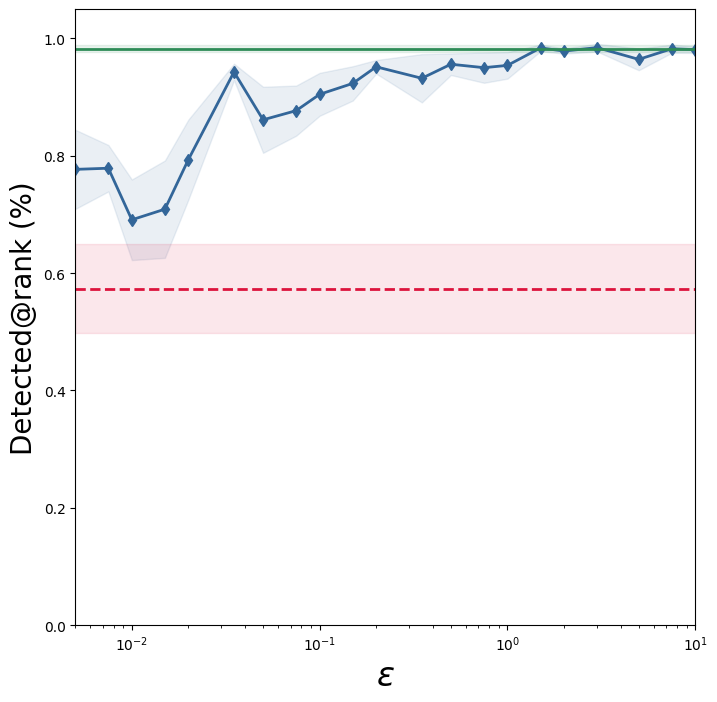

In [43]:
private_stats = all_dp_pref_df.groupby("epsilon")["inverted_rank_score"].agg(["mean","sem","std"])

orig_ks_stats = orig_perf_df[orig_perf_df["size_orgB"]==size_orgB]["inverted_rank_score"].agg(["mean","sem","std"])


rand_stats = rand_perf_df["inverted_rank_score"].agg(["mean","sem","std"])

f1, ax = plt.subplots(1,1, figsize=(8,8))



ax.plot(private_stats.index.values,private_stats["mean"].values, "-d",color="#336699",lw=2,label="Private")
ax.fill_between(private_stats.index.values, 
                private_stats["mean"].values- private_stats["sem"].values, 
                private_stats["mean"].values+ private_stats["sem"].values, color="#336699", alpha=0.1)


orig_ks_mean = orig_ks_stats["mean"]
print(orig_ks_mean)
plt.axhline(y=orig_ks_mean, color='seagreen', lw=2,label="Non-private") 
ax.fill_between(private_stats.index.values, 
                orig_ks_mean- orig_ks_stats["sem"], 
                orig_ks_mean+ orig_ks_stats["sem"], color="seagreen", alpha=0.1)


plt.axhline(y=rand_stats["mean"], color='crimson',linestyle="--", lw=2,label="Random") 
ax.fill_between(private_stats.index.values, 
                rand_stats["mean"]- rand_stats["sem"], 
                rand_stats["mean"]+ rand_stats["sem"], color="crimson", alpha=0.1)


# vertical line at x=5
ax.set_xscale("log")

ax.set_xlim(0.005,10)
ax.set_ylim(0.,1.05)

ax.set_xlabel("$\epsilon$",fontsize=24)
ax.set_ylabel("Detected@rank (%)",fontsize=20)
# ax.legend(ncol=3,fontsize=16)
# plt.savefig("/Users/shaharsomin/Documents/data/DP/social_media/plots/%s.pdf"%plot_name,bbox_inches='tight')

          # ,loc="lower center")

In [18]:
all_dp_pref_df

""


In [53]:
orig_ks_all_rank_df

,size_orgB,enchor_ind,rank_found,rank_norm,inverted_rank_score
0,188,0,1,0.000000,1.000000
1,188,1,95,0.502674,0.500000
2,188,2,55,0.288770,0.712766
3,188,3,1,0.000000,1.000000
4,188,4,2,0.005348,0.994681
5,188,5,5,0.021390,0.978723
6,188,6,7,0.032086,0.968085
7,188,7,1,0.000000,1.000000
8,188,8,23,0.117647,0.882979
9,188,9,17,0.085561,0.914894
